In [1]:
!nvidia-smi

Fri May 14 16:39:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    56W / 250W |      0MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test, inference_detector, show_result_pyplot, init_detector
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

apex is not installed
apex is not installed
apex is not installed
apex is not installed


In [3]:
# config file 들고오기
cfg = Config.fromfile('./configs/swin/cascade_mask_rcnn_swin_base_patch4_window12_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py')

cfg.seed = 42
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/cascade_mask_rcnn_swin_base_patch4_window12_mstrain_480-800_giou_4conv1f_adamw_3x_coco'

cfg.model.train_cfg = None

epoch = 7
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')

In [4]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
model = init_detector(cfg, checkpoint_path, device='cuda:0')
model.CLASSES = 11
from mmcv.runner import load_checkpoint
checkpoint = load_checkpoint(model, "./work_dirs/cascade_mask_rcnn_swin_base_patch4_window12_mstrain_480-800_giou_4conv1f_adamw_3x_coco/epoch_7.pth", map_location='cuda:0')
model.eval()

Use load_from_local loader


/opt/ml/code/mmdetection_trash/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


Use load_from_local loader


CascadeRCNN(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=51

In [6]:
img = '/opt/ml/input/data/batch_01_vt/0054.jpg'
result = inference_detector(model, img)
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/code/mmdetection_trash/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


Use load_from_local loader


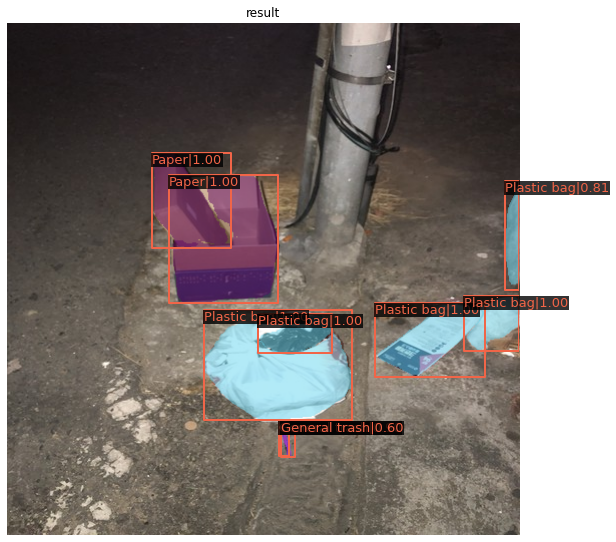

In [7]:
show_result_pyplot(model, img, result)

In [8]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 4.9 task/s, elapsed: 171s, ETA:     0s

In [9]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 11
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    out=out[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,8 0.9999355 174.91177 232.47076 461.57913 470....,batch_01_vt/0021.jpg
1,1 0.9754803 0.0 244.29741 310.4298 456.77875 2...,batch_01_vt/0028.jpg
2,1 0.98944944 74.28056 170.52335 364.9436 382.0...,batch_01_vt/0031.jpg
3,2 0.998019 297.00198 157.9739 351.92593 229.07...,batch_01_vt/0032.jpg
4,0 0.06720212 37.818344 457.99988 73.2719 472.8...,batch_01_vt/0070.jpg
